In [2]:
from numpy import array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

2022-09-12 19:58:39.059350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-12 19:58:39.059401: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [15]:
df = pd.read_excel('../raw_data/ratios.xlsx')
df

,Date,CMG_ETN,ROST_MMM,RE_ZTS,MCK_GLW,D_WBD,DVA_OMC,CARR_GOOGL,PGR_CTSH,RJF_MSFT,PKG_FIS
0,2020-09-08,13.506638,0.602499,1.329053,4.895305,3.251052,1.708033,0.378947,1.340740,0.238529,0.687761
1,2020-09-09,13.449365,0.592539,1.296271,4.776018,3.230514,1.795396,0.380226,1.365644,0.229566,0.681509
2,2020-09-10,13.527456,0.584031,1.266311,4.902900,3.140488,1.829054,0.372837,1.378674,0.234225,0.685586
3,2020-09-11,13.214654,0.570319,1.254798,4.882002,3.263059,1.820385,0.376656,1.334546,0.237897,0.700702
4,2020-09-14,12.823698,0.584702,1.257235,4.779497,3.176914,1.764097,0.377221,1.330864,0.243906,0.705164
...,...,...,...,...,...,...,...,...,...,...,...
500,2022-09-01,11.624631,0.702062,1.708488,10.741954,6.244125,1.304472,0.362584,1.949874,0.401536,1.505903
501,2022-09-02,11.773634,0.718372,1.745509,10.974962,6.265697,1.325083,0.366991,1.963902,0.404202,1.512838
502,2022-09-06,11.805430,0.743739,1.749554,11.003354,6.452890,1.338287,0.377305,1.968499,0.408292,1.523266
503,2022-09-07,11.897501,0.764330,1.754489,11.123370,6.576498,1.343383,0.379169,1.997801,0.409663,1.531353


In [17]:
ratio = 'CMG_ETN'
A = df[['Date',ratio]]
A.set_index('Date',inplace=True)
A.head()

,CMG_ETN
Date,
2020-09-08,13.506638
2020-09-09,13.449365
2020-09-10,13.527456
2020-09-11,13.214654
2020-09-14,12.823698


In [18]:
Daily_ratio = A[ratio].to_list()

In [19]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [31]:
X,y = split_sequence(Daily_ratio,200,30)
X_train =X[0:X.shape[0]-1]
X_test = X[X.shape[0]-1:]
X_train.shape
X_test.shape
y.shape
y_train = y[0:y.shape[0]-1]
y_test = y[y.shape[0]-1:]


X_train.shape

(275, 200)

In [34]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_train.shape,y_train.shape

((275, 200, 1), (275, 30))

In [86]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(200, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(200, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(30))
model.compile(optimizer='adam', loss='mse')


In [87]:
# fit model
model.fit(X_train, y_train, epochs=1000, verbose=0)


In [88]:
# demonstrate prediction
yhat = model.predict(X_test, verbose=0)
print(yhat)

[[0.7350004  0.75517905 0.7539702  0.7170357  0.742113   0.7153993
  0.72937405 0.73391145 0.73033196 0.7256184  0.71984696 0.7225187
  0.71405363 0.72268236 0.7129971  0.72725344 0.74215925 0.7438424
  0.75447464 0.7420984  0.7603387  0.75870514 0.81782246 0.82589406
  0.8581247  0.85271055 0.8554827  0.8614019  0.8395095  0.8463453 ]]


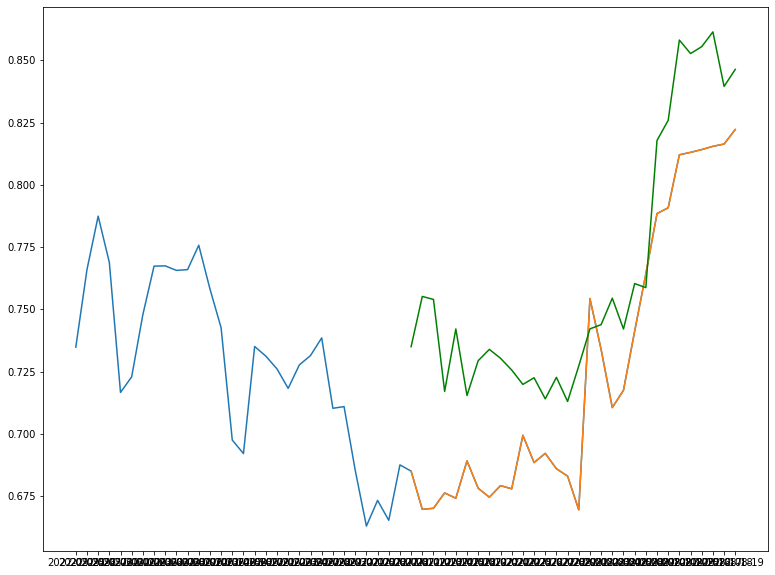

In [89]:
fig, ax = plt.subplots(1,1,figsize = (13,10))
ax.plot(A[ratio][-60:])
ax.plot(A.index[-30:],y_test[0])
ax.plot(A.index[-30:],yhat[0],c='green')

In [97]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [98]:
mean_absolute_percentage_error(y_test,yhat)

5.4636756902712875

In [53]:
df = pd.read_excel('../raw_data/weekly_prices.xlsx')
df

,Date,BRK-B,NVR,BIO,AZO,REGN,GS,COO,NOC,BLK,...,CZR,UAL,WYNN,BA,CCL,NCLH,RCL,CSCO,TECH,SYY
0,2022-03-08,318.519989,4648.430176,524.570007,1849.119995,614.739990,317.020386,380.353638,445.981628,653.277222,...,70.239998,32.240002,71.739998,173.800003,15.880000,15.960000,64.540001,53.548042,393.022705,74.453323
1,2022-03-09,325.399994,4814.160156,554.270020,1884.560059,623.429993,329.075012,386.693024,446.686554,683.217529,...,77.589996,34.900002,77.269997,178.559998,17.270000,17.309999,68.059998,55.044235,417.559174,78.852715
2,2022-03-10,325.299988,4776.560059,541.340027,1867.900024,630.359985,325.434937,385.263153,441.414673,687.110413,...,77.459999,35.200001,76.529999,178.389999,17.650000,17.799999,69.519997,53.853188,414.354858,79.070206
3,2022-03-11,326.600006,4752.540039,529.890015,1864.589966,642.580017,322.574219,379.923676,433.164429,677.097351,...,74.809998,34.869999,72.320000,176.229996,17.209999,17.490000,68.430000,53.833496,400.130096,76.934776
4,2022-03-14,329.980011,4622.000000,541.059998,1869.229980,656.409973,320.581543,381.773499,438.247650,687.435669,...,71.970001,35.020000,66.879997,175.520004,17.120001,17.059999,68.120003,53.449604,391.515381,75.886841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2022-09-01,282.429993,4116.660156,486.250000,2145.590088,600.630005,333.500000,300.119995,480.320007,659.919617,...,42.500000,35.180000,59.180000,153.660004,9.350000,13.010000,40.919998,45.290001,332.839996,81.849998
124,2022-09-02,277.670013,4093.129883,478.320007,2120.879883,580.619995,331.480011,295.529999,476.950012,653.179993,...,42.599998,35.310001,59.180000,151.820007,9.370000,13.050000,41.000000,44.590000,330.029999,80.779999
125,2022-09-06,276.589996,4040.010010,477.910004,2130.860107,573.969971,326.489990,296.179993,479.739990,661.630005,...,43.599998,36.580002,58.200001,152.389999,9.440000,13.320000,41.830002,44.470001,329.040009,80.430000
126,2022-09-07,281.040009,4133.509766,491.380005,2197.060059,596.440002,330.559998,306.109985,487.779999,674.219971,...,45.270000,38.599998,60.310001,155.949997,9.820000,14.040000,43.790001,45.020000,334.130005,82.900002


In [70]:
rt = pd.read_excel('../raw_data/cleaned_data.xlsx')
rt

,Date,CEG_BRK-B,GM_BRK-B,OGN_BRK-B,RE_BRK-B,RJF_BRK-B,WRB_BRK-B,CEG_NVR,OGN_NVR,CEG_BIO,...,OGN_RCL,CEG_CSCO,OGN_CSCO,BK_TECH,CEG_TECH,OGN_TECH,AES_SYY,CEG_SYY,OGN_SYY,PGR_SYY
0,2020-09-08,0.191391,0.148330,0.146393,0.925632,0.218103,0.183062,0.010646,0.008143,0.087058,...,0.445872,1.106282,0.846181,0.139495,0.170882,0.130706,0.291133,0.735322,0.562438,1.511189
1,2020-09-09,0.203353,0.145141,0.148884,0.926771,0.217023,0.185091,0.011132,0.008150,0.089060,...,0.466402,1.181462,0.865002,0.136420,0.179800,0.131640,0.284043,0.762960,0.558597,1.509046
2,2020-09-10,0.205062,0.138206,0.165105,0.908305,0.217032,0.183238,0.011296,0.009095,0.088713,...,0.512686,1.198182,0.964710,0.137240,0.182508,0.146945,0.279489,0.758514,0.610714,1.495181
3,2020-09-11,0.194920,0.139451,0.165006,0.902298,0.218865,0.184627,0.010496,0.008885,0.084113,...,0.518601,1.130746,0.957211,0.140364,0.175416,0.148495,0.284181,0.715410,0.605616,1.492602
4,2020-09-14,0.189069,0.141443,0.164588,0.908610,0.223847,0.186116,0.010039,0.008739,0.081723,...,0.510283,1.093480,0.951897,0.138173,0.169226,0.147315,0.276501,0.675712,0.588221,1.459536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,2022-09-01,NaN,0.136529,NaN,0.964310,0.370216,0.230075,NaN,NaN,NaN,...,NaN,NaN,NaN,0.124264,NaN,NaN,0.315822,NaN,NaN,1.511301
501,2022-09-02,NaN,0.138546,NaN,0.986819,0.372745,0.233262,NaN,NaN,NaN,...,NaN,NaN,NaN,0.124595,NaN,NaN,0.323719,NaN,NaN,1.515350
502,2022-09-06,NaN,0.139954,NaN,0.992082,0.373839,0.237536,NaN,NaN,NaN,...,NaN,NaN,NaN,0.125030,NaN,NaN,0.323884,NaN,NaN,1.522815
503,2022-09-07,NaN,0.142720,NaN,1.001352,0.376210,0.237902,NaN,NaN,NaN,...,NaN,NaN,NaN,0.126987,NaN,NaN,0.327865,NaN,NaN,1.534379


In [90]:
df_short = rt.dropna(axis=1).iloc[:, : 11].set_index('Date')
df_short

,GM_BRK-B,RE_BRK-B,RJF_BRK-B,WRB_BRK-B,RCL_BIO,EPAM_LRCX,MGM_LRCX,NCLH_LRCX,ALL_WHR,RE_WHR
Date,,,,,,,,,,
2020-09-08,0.148330,0.925632,0.218103,0.183062,0.149346,1.044698,0.078193,0.062577,0.547148,1.272954
2020-09-09,0.145141,0.926771,0.217023,0.185091,0.139803,1.083495,0.078470,0.060915,0.543580,1.259049
2020-09-10,0.138206,0.908305,0.217032,0.183238,0.139319,1.094331,0.078440,0.061611,0.551627,1.240722
2020-09-11,0.139451,0.902298,0.218865,0.184627,0.137301,1.095194,0.078997,0.060889,0.547973,1.209414
2020-09-14,0.141443,0.908610,0.223847,0.186116,0.139415,1.086575,0.077144,0.059547,0.538978,1.194544
...,...,...,...,...,...,...,...,...,...,...
2022-09-01,0.136529,0.964310,0.370216,0.230075,0.084154,0.954101,0.075109,0.030113,0.782303,1.755172
2022-09-02,0.138546,0.986819,0.372745,0.233262,0.085717,0.957997,0.076381,0.030334,0.790422,1.782875
2022-09-06,0.139954,0.992082,0.373839,0.237536,0.087527,0.962672,0.076788,0.031212,0.804570,1.817219


In [88]:
df_short.iloc[:, 1: ]

,GM_BRK-B,RE_BRK-B,RJF_BRK-B,WRB_BRK-B,RCL_BIO,EPAM_LRCX,MGM_LRCX,NCLH_LRCX,ALL_WHR,RE_WHR
0,0.148330,0.925632,0.218103,0.183062,0.149346,1.044698,0.078193,0.062577,0.547148,1.272954
1,0.145141,0.926771,0.217023,0.185091,0.139803,1.083495,0.078470,0.060915,0.543580,1.259049
2,0.138206,0.908305,0.217032,0.183238,0.139319,1.094331,0.078440,0.061611,0.551627,1.240722
3,0.139451,0.902298,0.218865,0.184627,0.137301,1.095194,0.078997,0.060889,0.547973,1.209414
4,0.141443,0.908610,0.223847,0.186116,0.139415,1.086575,0.077144,0.059547,0.538978,1.194544
...,...,...,...,...,...,...,...,...,...,...
500,0.136529,0.964310,0.370216,0.230075,0.084154,0.954101,0.075109,0.030113,0.782303,1.755172
501,0.138546,0.986819,0.372745,0.233262,0.085717,0.957997,0.076381,0.030334,0.790422,1.782875
502,0.139954,0.992082,0.373839,0.237536,0.087527,0.962672,0.076788,0.031212,0.804570,1.817219
503,0.142720,1.001352,0.376210,0.237902,0.089116,0.965949,0.077755,0.032500,0.810205,1.822314


In [59]:
rt.dropna(axis=1)

,Date,GM_BRK-B,RE_BRK-B,RJF_BRK-B,WRB_BRK-B,RCL_BIO,EPAM_LRCX,MGM_LRCX,NCLH_LRCX,ALL_WHR,...,ROST_EBAY,TJX_EBAY,GM_WELL,SRE_WELL,ULTA_WELL,AES_LYV,PFG_GE,BK_TECH,AES_SYY,PGR_SYY
0,2020-09-08,0.148330,0.925632,0.218103,0.183062,0.149346,1.044698,0.078193,0.062577,0.547148,...,1.829457,1.072479,0.573832,1.980035,4.143047,0.285490,0.800355,0.139495,0.291133,1.511189
1,2020-09-09,0.145141,0.926771,0.217023,0.185091,0.139803,1.083495,0.078470,0.060915,0.543580,...,1.761809,1.024049,0.558400,1.983218,4.123554,0.290486,0.793208,0.136420,0.284043,1.509046
2,2020-09-10,0.138206,0.908305,0.217032,0.183238,0.139319,1.094331,0.078440,0.061611,0.551627,...,1.746386,1.033555,0.536364,1.970140,4.135705,0.289070,0.793344,0.137240,0.279489,1.495181
3,2020-09-11,0.139451,0.902298,0.218865,0.184627,0.137301,1.095194,0.078997,0.060889,0.547973,...,1.722141,1.025499,0.550626,1.997845,4.147276,0.295308,0.805898,0.140364,0.284181,1.492602
4,2020-09-14,0.141443,0.908610,0.223847,0.186116,0.139415,1.086575,0.077144,0.059547,0.538978,...,1.805989,1.059937,0.551922,1.978725,4.154013,0.290080,0.784436,0.138173,0.276501,1.459536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,2022-09-01,0.136529,0.964310,0.370216,0.230075,0.084154,0.954101,0.075109,0.030113,0.782303,...,1.970069,1.425955,0.503526,2.193915,5.539958,0.286585,1.013107,0.124264,0.315822,1.511301
501,2022-09-02,0.138546,0.986819,0.372745,0.233262,0.085717,0.957997,0.076381,0.030334,0.790422,...,1.981183,1.440036,0.507319,2.199657,5.579322,0.291722,1.018914,0.124595,0.323719,1.515350
502,2022-09-06,0.139954,0.992082,0.373839,0.237536,0.087527,0.962672,0.076788,0.031212,0.804570,...,2.014870,1.461199,0.507472,2.200184,5.608548,0.292927,1.022589,0.125030,0.323884,1.522815
503,2022-09-07,0.142720,1.001352,0.376210,0.237902,0.089116,0.965949,0.077755,0.032500,0.810205,...,2.063144,1.474250,0.516416,2.233681,5.716622,0.298059,1.023512,0.126987,0.327865,1.534379


In [43]:
rt['CEG_BRK-B'].isna().sum()

92

In [52]:
sm = pd.read_excel('../raw_data/sma_60_days.xlsx')
sm

,RCL_BIO_SMA_60_days,EPAM_CHTR_SMA_60_days,IRM_CHTR_SMA_60_days,IT_CHTR_SMA_60_days,PYPL_CHTR_SMA_60_days,KEYS_FDX_SMA_60_days,AMP_DPZ_SMA_60_days,DE_DPZ_SMA_60_days,GM_DPZ_SMA_60_days,MET_DPZ_SMA_60_days,...,AMP_GLW_SMA_60_days,CMG_O_SMA_60_days,GM_O_SMA_60_days,GPC_O_SMA_60_days,GWW_O_SMA_60_days,NDAQ_O_SMA_60_days,AMP_FIS_SMA_60_days,GM_FIS_SMA_60_days,GM_WELL_SMA_60_days,SRE_WELL_SMA_60_days
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.075580,0.784849,0.109545,0.583554,0.184118,0.678868,0.647860,0.844039,0.089568,0.159977,...,7.515910,20.773478,0.507460,2.068384,7.284294,0.808039,2.641669,0.365268,0.438332,1.941195
60,0.075331,0.790424,0.109884,0.586456,0.184859,0.680670,0.648298,0.845146,0.089684,0.160038,...,7.523816,20.826808,0.507494,2.072301,7.296302,0.809908,2.647681,0.366326,0.439441,1.946951
61,0.075210,0.796730,0.110272,0.589795,0.185799,0.682853,0.649164,0.846813,0.089877,0.160187,...,7.530607,20.880867,0.507725,2.075749,7.309159,0.811881,2.653542,0.367433,0.440520,1.952554
62,0.075189,0.803340,0.110685,0.593377,0.186943,0.685431,0.650889,0.848961,0.090186,0.160462,...,7.544075,20.954867,0.508597,2.080773,7.324825,0.814335,2.661629,0.368834,0.441979,1.958378


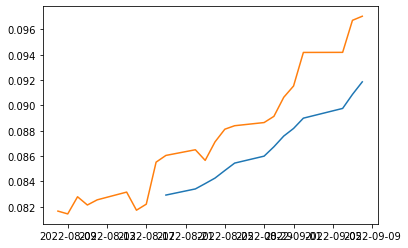

In [23]:
plt.plot(rt['Date'], sm[sm.columns[0]])
plt.plot(rt['Date'],rt['AES_BRK-B'])

In [91]:
preds = pd.read_csv('../raw_data/CNN_preds.csv')

In [92]:
preds

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Date
0,1.609288,1.610126,1.610462,1.610395,1.608829,1.608894,1.607815,1.608094,1.608593,1.609454,...,1.606119,1.606033,1.603496,1.601977,1.601257,1.600961,1.602015,1.600941,1.600061,2022-09-09


In [105]:
ratios = pd.read_excel('../raw_data/cleaned_data.xlsx')
ratios['Date'] = pd.to_datetime(ratios['Date'])

In [113]:
import datetime
df = pd.DataFrame()
start_date = (ratios['Date'].iloc[-1]+ datetime.timedelta(days=1)).strftime("%Y-%m-%d")
end_date = (ratios['Date'].iloc[-1]+ datetime.timedelta(days=30)).strftime("%Y-%m-%d")
df['Date'] = pd.date_range(start_date,end_date)
df

,Date
0,2022-09-09
1,2022-09-10
2,2022-09-11
3,2022-09-12
4,2022-09-13
5,2022-09-14
6,2022-09-15
7,2022-09-16
8,2022-09-17
9,2022-09-18


In [114]:
df = pd.read_csv('../raw_data/CNN_preds.csv')
df

,Date,GM_BRK-B,RE_BRK-B,RJF_BRK-B,WRB_BRK-B,RCL_BIO,EPAM_LRCX,MGM_LRCX,NCLH_LRCX,ALL_WHR,RE_WHR
0,2022-09-09,0.116453,0.941425,0.328860,0.205030,0.113177,0.654944,0.072447,0.037591,0.593234,1.531174
1,2022-09-10,0.118766,0.927849,0.333529,0.207874,0.113083,0.661150,0.072451,0.037395,0.597389,1.530782
2,2022-09-11,0.119246,0.934138,0.335845,0.205487,0.112719,0.674037,0.072405,0.037256,0.603157,1.535235
3,2022-09-12,0.119997,0.901765,0.335078,0.206963,0.112585,0.692049,0.072368,0.037127,0.609853,1.539009
4,2022-09-13,0.119508,0.909237,0.336469,0.205177,0.112394,0.714590,0.072392,0.037068,0.619087,1.547193
5,2022-09-14,0.121400,0.891154,0.342471,0.206814,0.112186,0.738978,0.072423,0.036899,0.629738,1.561546
6,2022-09-15,0.122723,0.905173,0.343622,0.204786,0.111999,0.768968,0.072469,0.036831,0.638092,1.575498
7,2022-09-16,0.124769,0.904856,0.348132,0.204738,0.111718,0.796192,0.072416,0.036651,0.648831,1.588712
8,2022-09-17,0.126392,0.901213,0.355202,0.204916,0.111491,0.826658,0.072450,0.036645,0.658832,1.602382
9,2022-09-18,0.127235,0.901774,0.358883,0.208281,0.111414,0.855125,0.072422,0.036575,0.667176,1.616363


In [116]:
df['Date'].iat[29]

'2022-10-08'

In [117]:
ratios = pd.read_excel('../raw_data/cleaned_data.xlsx')

In [118]:
ratios

,Date,CEG_BRK-B,GM_BRK-B,OGN_BRK-B,RE_BRK-B,RJF_BRK-B,WRB_BRK-B,CEG_NVR,OGN_NVR,CEG_BIO,...,OGN_RCL,CEG_CSCO,OGN_CSCO,BK_TECH,CEG_TECH,OGN_TECH,AES_SYY,CEG_SYY,OGN_SYY,PGR_SYY
0,2020-09-08,0.191391,0.148330,0.146393,0.925632,0.218103,0.183062,0.010646,0.008143,0.087058,...,0.445872,1.106282,0.846181,0.139495,0.170882,0.130706,0.291133,0.735322,0.562438,1.511189
1,2020-09-09,0.203353,0.145141,0.148884,0.926771,0.217023,0.185091,0.011132,0.008150,0.089060,...,0.466402,1.181462,0.865002,0.136420,0.179800,0.131640,0.284043,0.762960,0.558597,1.509046
2,2020-09-10,0.205062,0.138206,0.165105,0.908305,0.217032,0.183238,0.011296,0.009095,0.088713,...,0.512686,1.198182,0.964710,0.137240,0.182508,0.146945,0.279489,0.758514,0.610714,1.495181
3,2020-09-11,0.194920,0.139451,0.165006,0.902298,0.218865,0.184627,0.010496,0.008885,0.084113,...,0.518601,1.130746,0.957211,0.140364,0.175416,0.148495,0.284181,0.715410,0.605616,1.492602
4,2020-09-14,0.189069,0.141443,0.164588,0.908610,0.223847,0.186116,0.010039,0.008739,0.081723,...,0.510283,1.093480,0.951897,0.138173,0.169226,0.147315,0.276501,0.675712,0.588221,1.459536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,2022-09-01,NaN,0.136529,NaN,0.964310,0.370216,0.230075,NaN,NaN,NaN,...,NaN,NaN,NaN,0.124264,NaN,NaN,0.315822,NaN,NaN,1.511301
501,2022-09-02,NaN,0.138546,NaN,0.986819,0.372745,0.233262,NaN,NaN,NaN,...,NaN,NaN,NaN,0.124595,NaN,NaN,0.323719,NaN,NaN,1.515350
502,2022-09-06,NaN,0.139954,NaN,0.992082,0.373839,0.237536,NaN,NaN,NaN,...,NaN,NaN,NaN,0.125030,NaN,NaN,0.323884,NaN,NaN,1.522815
503,2022-09-07,NaN,0.142720,NaN,1.001352,0.376210,0.237902,NaN,NaN,NaN,...,NaN,NaN,NaN,0.126987,NaN,NaN,0.327865,NaN,NaN,1.534379


In [123]:
ratios['Date'].iat[-60]

Timestamp('2022-06-14 00:00:00')

In [135]:
df = pd.read_csv('../raw_data/CNN_preds.csv')
df.head()

,Date,GM_BRK-B,RE_BRK-B,RJF_BRK-B,WRB_BRK-B,RCL_BIO,EPAM_LRCX,MGM_LRCX,NCLH_LRCX,ALL_WHR,RE_WHR
0,2022-09-09,0.116453,0.941425,0.328860,0.205030,0.113177,0.654944,0.072447,0.037591,0.593234,1.531174
1,2022-09-10,0.118766,0.927849,0.333529,0.207874,0.113083,0.661150,0.072451,0.037395,0.597389,1.530782
2,2022-09-11,0.119246,0.934138,0.335845,0.205487,0.112719,0.674037,0.072405,0.037256,0.603157,1.535235
3,2022-09-12,0.119997,0.901765,0.335078,0.206963,0.112585,0.692049,0.072368,0.037127,0.609853,1.539009
4,2022-09-13,0.119508,0.909237,0.336469,0.205177,0.112394,0.714590,0.072392,0.037068,0.619087,1.547193


In [136]:
df['Date'] = (pd.to_datetime(df['Date']) - datetime.timedelta(days=30))

In [139]:
df.to_csv('../raw_data/CNN_preds.csv' ,index=False)

In [154]:
from datetime import datetime
from dateutil.relativedelta import relativedelta, FR
lastFriday = datetime.now() + relativedelta(weekday=FR(-1))
llFriday = lastFriday- timedelta(days=7)
lllFriday  =llFriday - timedelta(days=7)
lllFriday

datetime.datetime(2022, 8, 26, 11, 44, 51, 690689)

In [158]:
df = pd.read_excel('../raw_data/cleaned_data.xlsx')
df.head()

,Date,CEG_BRK-B,GM_BRK-B,OGN_BRK-B,RE_BRK-B,RJF_BRK-B,WRB_BRK-B,CEG_NVR,OGN_NVR,CEG_BIO,...,OGN_RCL,CEG_CSCO,OGN_CSCO,BK_TECH,CEG_TECH,OGN_TECH,AES_SYY,CEG_SYY,OGN_SYY,PGR_SYY
0,2020-09-08,0.191391,0.148330,0.146393,0.925632,0.218103,0.183062,0.010646,0.008143,0.087058,...,0.445872,1.106282,0.846181,0.139495,0.170882,0.130706,0.291133,0.735322,0.562438,1.511189
1,2020-09-09,0.203353,0.145141,0.148884,0.926771,0.217023,0.185091,0.011132,0.008150,0.089060,...,0.466402,1.181462,0.865002,0.136420,0.179800,0.131640,0.284043,0.762960,0.558597,1.509046
2,2020-09-10,0.205062,0.138206,0.165105,0.908305,0.217032,0.183238,0.011296,0.009095,0.088713,...,0.512686,1.198182,0.964710,0.137240,0.182508,0.146945,0.279489,0.758514,0.610714,1.495181
3,2020-09-11,0.194920,0.139451,0.165006,0.902298,0.218865,0.184627,0.010496,0.008885,0.084113,...,0.518601,1.130746,0.957211,0.140364,0.175416,0.148495,0.284181,0.715410,0.605616,1.492602
4,2020-09-14,0.189069,0.141443,0.164588,0.908610,0.223847,0.186116,0.010039,0.008739,0.081723,...,0.510283,1.093480,0.951897,0.138173,0.169226,0.147315,0.276501,0.675712,0.588221,1.459536


In [162]:
df_short = df.dropna(axis=1).iloc[:, :11].set_index('Date')
df_short

,GM_BRK-B,RE_BRK-B,RJF_BRK-B,WRB_BRK-B,RCL_BIO,EPAM_LRCX,MGM_LRCX,NCLH_LRCX,ALL_WHR,RE_WHR
Date,,,,,,,,,,
2020-09-08,0.148330,0.925632,0.218103,0.183062,0.149346,1.044698,0.078193,0.062577,0.547148,1.272954
2020-09-09,0.145141,0.926771,0.217023,0.185091,0.139803,1.083495,0.078470,0.060915,0.543580,1.259049
2020-09-10,0.138206,0.908305,0.217032,0.183238,0.139319,1.094331,0.078440,0.061611,0.551627,1.240722
2020-09-11,0.139451,0.902298,0.218865,0.184627,0.137301,1.095194,0.078997,0.060889,0.547973,1.209414
2020-09-14,0.141443,0.908610,0.223847,0.186116,0.139415,1.086575,0.077144,0.059547,0.538978,1.194544
...,...,...,...,...,...,...,...,...,...,...
2022-09-01,0.136529,0.964310,0.370216,0.230075,0.084154,0.954101,0.075109,0.030113,0.782303,1.755172
2022-09-02,0.138546,0.986819,0.372745,0.233262,0.085717,0.957997,0.076381,0.030334,0.790422,1.782875
2022-09-06,0.139954,0.992082,0.373839,0.237536,0.087527,0.962672,0.076788,0.031212,0.804570,1.817219


In [170]:
pl_one_dict = {}
pl_three_dict = {}
ptf_value = 10000
for col in df_short.columns:
    delta_one = df_short[col][19] / df_short[col][0]
    pl_one_dict[col] = round(ptf_value * delta_one, 2)
for col in df_short.columns:
    delta_three = df_short[col][59] / df_short[col][0]
    pl_three_dict[col] = round(ptf_value * delta_three, 2)
pl_three_dict

{'GM_BRK-B': 13084.92,
 'RE_BRK-B': 10412.61,
 'RJF_BRK-B': 12090.27,
 'WRB_BRK-B': 10298.35,
 'RCL_BIO': 9406.72,
 'EPAM_LRCX': 6854.06,
 'MGM_LRCX': 8018.87,
 'NCLH_LRCX': 7982.84,
 'ALL_WHR': 9914.0,
 'RE_WHR': 9475.49}

In [173]:
df = pd.read_excel('../raw_data/cleaned_data.xlsx')
df.head()

,Date,CEG_BRK-B,GM_BRK-B,OGN_BRK-B,RE_BRK-B,RJF_BRK-B,WRB_BRK-B,CEG_NVR,OGN_NVR,CEG_BIO,...,OGN_RCL,CEG_CSCO,OGN_CSCO,BK_TECH,CEG_TECH,OGN_TECH,AES_SYY,CEG_SYY,OGN_SYY,PGR_SYY
0,2020-09-08,0.191391,0.148330,0.146393,0.925632,0.218103,0.183062,0.010646,0.008143,0.087058,...,0.445872,1.106282,0.846181,0.139495,0.170882,0.130706,0.291133,0.735322,0.562438,1.511189
1,2020-09-09,0.203353,0.145141,0.148884,0.926771,0.217023,0.185091,0.011132,0.008150,0.089060,...,0.466402,1.181462,0.865002,0.136420,0.179800,0.131640,0.284043,0.762960,0.558597,1.509046
2,2020-09-10,0.205062,0.138206,0.165105,0.908305,0.217032,0.183238,0.011296,0.009095,0.088713,...,0.512686,1.198182,0.964710,0.137240,0.182508,0.146945,0.279489,0.758514,0.610714,1.495181
3,2020-09-11,0.194920,0.139451,0.165006,0.902298,0.218865,0.184627,0.010496,0.008885,0.084113,...,0.518601,1.130746,0.957211,0.140364,0.175416,0.148495,0.284181,0.715410,0.605616,1.492602
4,2020-09-14,0.189069,0.141443,0.164588,0.908610,0.223847,0.186116,0.010039,0.008739,0.081723,...,0.510283,1.093480,0.951897,0.138173,0.169226,0.147315,0.276501,0.675712,0.588221,1.459536


In [9]:
df = pd.read_excel('../raw_data/ratios.xlsx')
df

,Date,CMG_ETN,ROST_MMM,RE_ZTS,MCK_GLW,D_WBD,DVA_OMC,CARR_GOOGL,PGR_CTSH,RJF_MSFT,PKG_FIS
0,2020-09-08,13.506638,0.602499,1.329053,4.895305,3.251052,1.708033,0.378947,1.340740,0.238529,0.687761
1,2020-09-09,13.449365,0.592539,1.296271,4.776018,3.230514,1.795396,0.380226,1.365644,0.229566,0.681509
2,2020-09-10,13.527456,0.584031,1.266311,4.902900,3.140488,1.829054,0.372837,1.378674,0.234225,0.685586
3,2020-09-11,13.214654,0.570319,1.254798,4.882002,3.263059,1.820385,0.376656,1.334546,0.237897,0.700702
4,2020-09-14,12.823698,0.584702,1.257235,4.779497,3.176914,1.764097,0.377221,1.330864,0.243906,0.705164
...,...,...,...,...,...,...,...,...,...,...,...
500,2022-09-01,11.624631,0.702062,1.708488,10.741954,6.244125,1.304472,0.362584,1.949874,0.401536,1.505903
501,2022-09-02,11.773634,0.718372,1.745509,10.974962,6.265697,1.325083,0.366991,1.963902,0.404202,1.512838
502,2022-09-06,11.805430,0.743739,1.749554,11.003354,6.452890,1.338287,0.377305,1.968499,0.408292,1.523266
503,2022-09-07,11.897501,0.764330,1.754489,11.123370,6.576498,1.343383,0.379169,1.997801,0.409663,1.531353


In [28]:
df.dtypes

Date          datetime64[ns]
CMG_ETN              float64
ROST_MMM             float64
RE_ZTS               float64
MCK_GLW              float64
D_WBD                float64
DVA_OMC              float64
CARR_GOOGL           float64
PGR_CTSH             float64
RJF_MSFT             float64
PKG_FIS              float64
dtype: object